In [1]:
import obj_functions.push_problems
import numpy as np
import torch

example

In [2]:
f_class = obj_functions.push_problems.push4
# set initial target location (unknown to the robot and only
# used for distance calculation after it has finished pushing)
tx_1 = 3.5; ty_1 = 4
# instantiate the test problem
f = f_class(tx_1, ty_1)
# evaluate some solution x in [0, 1]^4
x = torch.tensor(np.array([[0., 0., 0.2, 0.3],[0.3, 0.4, 0.2, 0.3]]))
f(x)

tensor([4.6133, 2.5119], dtype=torch.float64)

# import

In [3]:
from known_boundary.GP import optimise,optimise_warp,optimise_warp_no_boundary
from known_boundary.utlis import Trans_function, get_initial_points,transform
from known_boundary.acquisition_function import EI_acquisition_opt,MES_acquisition_opt,Warped_EI_acquisition_opt,Warped_TEI2_acquisition_opt,Warped_TEI1_acquisition_opt,LCB_acquisition_opt,ERM_acquisition_opt
import numpy as np
import GPy
import torch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell
from botorch.utils.transforms import unnormalize,normalize

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
tx_1 = 3.5; ty_1 = 4
# instantiate the test problem
fun = f_class(tx_1, ty_1)
dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)

n_init = 3*dim
iter_num = 25*dim
N = 100

fstar = 0.
fun = Trans_function(fun,fstar,min=True)

In [5]:
x = torch.tensor(np.array([[0., 0., 0., 0.3],[0.3, 0.4, 0., 0.3]]))
f(x)

tensor([5.3151, 5.3117], dtype=torch.float64)

# EI

In [74]:
BO_EI = []

for exp in range(N):
    
    print(exp)
    
    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    best_record = [Y_BO.min().item()]
    np.random.seed(1234)

    for i in range(iter_num):
        
            #print(i)
        
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            minimal = train_Y.min().item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            if i%2 == 0:
                #print('tranin')
                res = optimise(train_X,train_Y)
                kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            
            #print(best_record[-1])
            
            
    best_record = np.array(best_record)+fstar 
    BO_EI.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


# MES

In [75]:
BO_MES = []

for exp in range(N):

    seed = exp
    
    print(exp)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)
    
    fstar_mes = 0. 

    best_record = [Y_BO.min().item()]

    np.random.seed(1234)

    for i in range(iter_num):
            print(i)
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            
            fstar_standard = (fstar_mes - Y_BO.mean()) / Y_BO.std()
            fstar_standard = fstar_standard.item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            if i%2 == 0:
                res = optimise(train_X,train_Y)
                kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = MES_acquisition_opt(m,standard_bounds,fstar_standard)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)+fstar 
    BO_MES.append(best_record)

0
0
3.118562809192764
1
3.118562809192764
2
2.5574641323756664
3
1.2368141611048307
4
1.2368141611048307
5
1.2368141611048307
6
1.2368141611048307
7
1.2368141611048307
8
1.2368141611048307
9
0.8548835078448984
10
0.8548835078448984
11
0.8548835078448984
12
0.8548835078448984
13
0.8548835078448984
14
0.8548835078448984
15
0.8548835078448984
16
0.8548835078448984
17
0.8548835078448984
18
0.8548835078448984
19
0.8548835078448984
20
0.8548835078448984
21
0.8548835078448984
22
0.8548835078448984
23
0.8548835078448984
24
0.8548835078448984
25
0.8548835078448984
26
0.8548835078448984
27
0.8548835078448984
28
0.8548835078448984
29
0.8548835078448984
30
0.8548835078448984
31
0.8548835078448984
32
0.8548835078448984
33
0.8548835078448984
34
0.8548835078448984
35
0.8548835078448984
36
0.8548835078448984
37
0.8548835078448984
38
0.8548835078448984
39
0.8548835078448984
40
0.8548835078448984
41
0.8548835078448984
42
0.8548835078448984
43
0.8548835078448984
44
0.8548835078448984
45
0.854883507844898

# TEI

In [76]:
BO_TEI = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)
    
    fstar0 = 0.


    best_record = [Y_BO.min().item()]

    np.random.seed(1234)


    for i in range(iter_num):
        
            print(i)
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            fstar_standard = (fstar0 - Y_BO.mean()) / Y_BO.std()
            fstar_standard = fstar_standard.item()
            
            minimal = train_Y.min().item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            if i%2 == 0:
                res = optimise(train_X,train_Y)
            # print('lengthscale is: ',np.sqrt(res[0])) 
            # print('variance is: ',res[1])
                kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal,f_star=fstar_standard)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)+fstar 
    BO_TEI.append(best_record)

0
0


3.118562809192764
1
3.118562809192764
2
2.3665451424439734
3
2.1853446113800534
4
2.1853446113800534
5
2.1853446113800534
6
2.1853446113800534
7
2.1853446113800534
8
2.1853446113800534
9
2.1853446113800534
10
2.1853446113800534
11
2.1853446113800534
12
2.1853446113800534
13
1.846926428639744
14
1.0971164530635562
15
1.0971164530635562
16
1.0971164530635562
17
1.0971164530635562
18
1.0971164530635562
19
1.0971164530635562
20
1.0971164530635562
21
1.0971164530635562
22
1.0971164530635562
23
1.0971164530635562
24
1.0971164530635562
25
1.0971164530635562
26
1.0971164530635562
27
1.0971164530635562
28
1.0971164530635562
29
1.0971164530635562
30
1.0971164530635562
31
0.4342084247621009
32
0.4342084247621009
33
0.4342084247621009
34
0.4342084247621009
35
0.044496739290006526
36
0.044496739290006526
37
0.044496739290006526
38
0.044496739290006526
39
0.044496739290006526
40
0.044496739290006526
41
0.044496739290006526
42
0.044496739290006526
43
0.044496739290006526
44
0.044496739290006526
45
0.

# ERM

In [77]:
BO_ERM = []
for exp in range(N):

    print(exp)  
    seed = exp
    
    fstar0 = 0.
    Trans = False

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
                [fun(x) for x in X_BO], dtype=dtype, device=device
            ).reshape(-1,1)

    best_record = [Y_BO.min().item()]

    np.random.seed(1234)

    for i in range(iter_num):

        print(i)
        train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
        train_X = normalize(X_BO, bounds)
        
        train_Y = train_Y.numpy()
        train_X = train_X.numpy()
        

        fstar_standard = (fstar0 - Y_BO.mean()) / Y_BO.std()
        fstar_standard = fstar_standard.item()
        
        if not Trans:
            minimal = np.min(train_X)
            if i%2 == 0:
                res = optimise(train_X,train_Y)
                kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))

            standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
            
            beta = np.sqrt(np.log(train_X.shape[0]))
            _,lcb = LCB_acquisition_opt(m,standard_bounds,beta)
            if lcb < fstar_standard:
                Trans = True
        
        else:                        
            train_Y_transform = transform(y=train_Y,fstar=fstar_standard)
            mean_temp = np.mean(train_Y_transform)
            
            if i%2 == 0:
                res = optimise(train_X,(train_Y_transform-mean_temp))
                kernel = GPy.kern.RBF(input_dim=dim,lengthscale= np.sqrt(res[0]),variance=res[1]) 
            m = GPy.models.GPRegression(train_X, train_Y_transform-mean_temp,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))
            standard_next_X,erm_value = ERM_acquisition_opt(m,bounds=standard_bounds,fstar=fstar_standard,mean_temp=mean_temp)
        
        
        X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)     
        Y_next = fun(X_next).reshape(-1,1)

        # Append data
        X_BO = torch.cat((X_BO, X_next), dim=0)
        Y_BO = torch.cat((Y_BO, Y_next), dim=0)

        best_value = float(Y_BO.min())
        best_record.append(best_value)
        
        print(best_record[-1])


    best_record = np.array(best_record)+fstar
    BO_ERM.append(best_record)

0


0
3.118562809192764
1
3.118562809192764
2
3.118562809192764
3
3.118562809192764
4
3.118562809192764
5
3.118562809192764
6
3.118562809192764
7
3.118562809192764
8
3.118562809192764
9
3.118562809192764
10
3.118562809192764
11
3.118562809192764
12
3.118562809192764
13
3.118562809192764
14
3.118562809192764
15
3.118562809192764
16
3.118562809192764
17
1.8820673458980015
18
1.8820673458980015
19
1.8820673458980015
20
1.8820673458980015
21
1.8187734227140633
22
1.8187734227140633
23
1.8187734227140633
24
1.8187734227140633
25
1.8187734227140633
26
1.8187734227140633
27
1.8187734227140633
28
1.8187734227140633
29
1.8187734227140633
30
1.8187734227140633
31
1.8187734227140633
32
1.7470888756270544
33
1.7470888756270544
34
1.7470888756270544
35
1.7411350644368617
36
1.7305033614253786
37
1.7305033614253786
38
1.7305033614253786
39
1.7305033614253786
40
1.7305033614253786
41
1.7305033614253786
42
1.7305033614253786
43
1.6990509064019599
44
1.6990509064019599
45
1.6990509064019599
46
1.6990509064

# logGP+TEI

In [8]:
Warped_BO_logTEI = []

for exp in range(N):

    seed = exp
    
    print(exp)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)



    best_record = [Y_BO.min().item()]
    np.random.seed(1234)

    for i in range(iter_num):

            print('inner loop: ',i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            # train the GP
            if i%2 == 0:
                res = optimise_warp(train_X, train_Y)
                lengthscale = np.sqrt(res[0])
                variance = res[1]
                c = res[2]
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))
            
            standard_next_X = Warped_TEI2_acquisition_opt(model=m,bounds=standard_bounds,f_best=best_record[-1],c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)+fstar         
    Warped_BO_logTEI.append(best_record)

0
inner loop:  0
3.118562809192764
inner loop:  1
3.118562809192764
inner loop:  2
2.94506398116921
inner loop:  3
2.94506398116921
inner loop:  4
2.94506398116921
inner loop:  5
2.94506398116921
inner loop:  6
2.7901041218033553
inner loop:  7
2.7901041218033553
inner loop:  8
2.7901041218033553
inner loop:  9
2.7901041218033553
inner loop:  10
2.7901041218033553
inner loop:  11
2.5023484365608493
inner loop:  12
2.5023484365608493
inner loop:  13
2.5023484365608493
inner loop:  14
2.5023484365608493
inner loop:  15
2.5023484365608493
inner loop:  16
2.4788010266863227
inner loop:  17
2.4788010266863227
inner loop:  18
2.4788010266863227
inner loop:  19
2.4788010266863227
inner loop:  20
1.667928577890853
inner loop:  21
1.1148005338798166
inner loop:  22
1.1148005338798166
inner loop:  23
1.1148005338798166
inner loop:  24
1.1148005338798166
inner loop:  25
1.1148005338798166
inner loop:  26
1.1148005338798166
inner loop:  27
1.061071751177061
inner loop:  28
1.061071751177061
inner 

Text(0.5, 1.0, 'Robot Push 4D')

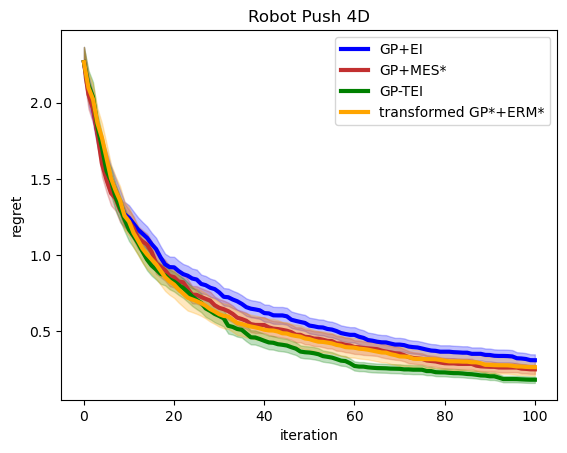

In [84]:
import  os
import numpy as np
import matplotlib.pyplot as plt

fstar = 0.

total_record = (np.array(BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = (np.array(BO_MES)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+MES*',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = (np.array(BO_TEI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP-TEI',color='green')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='green')

total_record = (np.array(BO_ERM)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='transformed GP*+ERM*',color='orange')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='orange')


total_record = (np.array(Warped_BO_logTEI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP*+TEI*',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

plt.xlabel('iteration')
plt.ylabel('regret')

plt.legend()
plt.title('Robot Push 4D')

In [85]:
np.savetxt('exp_res2/Push4D_GP+EI', BO_EI, delimiter=',')
np.savetxt('exp_res2/Push4D_GP+MES', BO_MES, delimiter=',')
np.savetxt('exp_res2/Push4D_GP+TEI', BO_TEI, delimiter=',')
np.savetxt('exp_res2/Push4D_transformedGP+ERM', BO_ERM, delimiter=',')

In [9]:
np.savetxt('exp_res2/Push4D_logGP+logTEI', Warped_BO_logTEI, delimiter=',')

In [ ]:
Y_BO